In [1]:
import pandas as pd
import numpy as np
import random
import json
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

np.random.seed(42)
random.seed(42)

In [2]:
n_farms = 200
years = list(range(2014, 2025))

states = [
    "Adamawa", "Bauchi", "Benue", "Borno", "FCT",
    "Gombe", "Jigawa", "Kaduna", "Kano", "Katsina",
    "Kebbi", "Kogi", "Kwara", "Nasarawa", "Niger",
    "Plateau", "Sokoto", "Taraba", "Yobe", "Zamfara"
]


crops = ["Sorghum", "Millet", "Maize", "Cowpea", "Groundnut",
        "Guna melon", "Sesame", "Rice", "Wheat", "Cassava",
        "Yam", "Sweet potato", "Okra", "Soybeans", "Cotton"]

anomaly_table = {
    2014: {"rain_pct": -0.03, "temp_delta": +0.08},
    2015: {"rain_pct": -0.12, "temp_delta": +0.20},
    2016: {"rain_pct": +0.04, "temp_delta": -0.02},
    2017: {"rain_pct": -0.07, "temp_delta": +0.10},
    2018: {"rain_pct": +0.06, "temp_delta": -0.05},
    2019: {"rain_pct": +0.02, "temp_delta": +0.02},
    2020: {"rain_pct": -0.10, "temp_delta": +0.25},
    2021: {"rain_pct": -0.05, "temp_delta": +0.12},
    2022: {"rain_pct": +0.08, "temp_delta": -0.03},
    2023: {"rain_pct": -0.06, "temp_delta": +0.05},
    2024: {"rain_pct": +0.03, "temp_delta": +0.09},
}

In [3]:
sahel_states = {"Sokoto","Kebbi","Katsina","Zamfara"}
sudan_states = {"Kano","Jigawa"}

def sample_rainfall_base(state):
    if state in sahel_states:
        return np.random.normal(450, 120)
    elif state in sudan_states:
        return np.random.normal(800, 150)
    else:
        return np.random.normal(950, 150)

def sample_temp_base(state):
    return np.random.normal(28.0, 2.3)

def sample_ndvi_mean_base():
    return np.random.uniform(0.15, 0.6)

def compute_ndvi_peak_from_mean(ndvi_mean_val):
    peak = ndvi_mean_val + abs(np.random.normal(0.15, 0.07))
    return min(peak, 0.95)

def sample_soil_ph():
    return np.random.uniform(4.8,7.5)

def sample_soc_pct():
    return np.random.uniform(0.5,2.5)

def sample_fertilizer_rate():
    if np.random.rand() < 0.45:
        return np.random.uniform(0,10)
    else:
        return max(0.0, np.random.normal(25,12))

def sample_pesticide_rate():
    return max(0.0, np.random.normal(1.2,0.8))

def sample_farm_size_ha():
    return float(np.exp(np.random.normal(np.log(1.5),0.7)))

def sample_irrigated_area(fs_ha):
    if np.random.rand() < 0.08:
        return np.random.uniform(0.05, 0.6*fs_ha)
    else:
        return 0.0

def simulate_yield_for_crop(crop_name, ndvi_val, fert_rate):
    base = {
        'Sorghum': np.random.normal(1.2, 0.4),
        'Millet': np.random.normal(0.9, 0.25),
        'Maize': np.random.normal(1.8, 0.6),
        'Cowpea': np.random.normal(0.7, 0.25),
        'Groundnut': np.random.normal(1.0, 0.3),
        'Guna melon': np.random.normal(1.5, 0.5),
        'Sesame': np.random.normal(0.5, 0.2),
        'Rice': np.random.normal(2.0, 0.6),
        'Wheat': np.random.normal(1.5, 0.5),
        'Cassava': np.random.normal(3.0, 1.0),
        'Yam': np.random.normal(2.5, 0.8),
        'Sweet potato': np.random.normal(2.2, 0.7),
        'Okra': np.random.normal(1.2, 0.4),
        'Soybeans': np.random.normal(1.1, 0.35),
        'Cotton': np.random.normal(1.8, 0.6)
    }[crop_name]
    ndvi_factor = 1 + (ndvi_val - 0.3)
    fert_factor = 1 + (min(fert_rate,100)/100)*0.25
    y = base * ndvi_factor * fert_factor
    y = max(0.1, y + np.random.normal(0,0.15))
    return min(y, 8.0)

def make_random_polygon_geojson():
    lat = np.random.uniform(6.0,13.8)
    lon = np.random.uniform(2.0,14.0)
    delta = np.random.uniform(0.0005, 0.01)
    coords = [
        [round(lon-delta,6), round(lat-delta,6)],
        [round(lon-delta,6), round(lat+delta,6)],
        [round(lon+delta,6), round(lat+delta,6)],
        [round(lon+delta,6), round(lat-delta,6)],
        [round(lon-delta,6), round(lat-delta,6)],
    ]
    return json.dumps({'type':'Polygon','coordinates':[coords]})

In [4]:
farms = []
for i in range(n_farms):
    st = random.choice(states)
    fs = sample_farm_size_ha()
    farms.append({
        'farm_id': f'F{i+1:05d}',
        'state': st,
        'polygon_geojson': make_random_polygon_geojson(),
        'farm_size_ha': round(fs,3),
        'soil_ph': round(sample_soil_ph(),2),
        'soil_org_carbon_pct': round(sample_soc_pct(),2),
    })

len(farms), farms[0]

(200,
 {'farm_id': 'F00001',
  'state': 'Borno',
  'polygon_geojson': '{"type": "Polygon", "coordinates": [[[9.18192, 11.707571], [9.18192, 11.711535], [9.185884, 11.711535], [9.185884, 11.707571], [9.18192, 11.707571]]]}',
  'farm_size_ha': 2.124,
  'soil_ph': 5.22,
  'soil_org_carbon_pct': 0.62})

In [5]:
rows = []
for farm in farms:
    for yr in years:
        rain_base = float(max(10.0, sample_rainfall_base(farm['state'])))
        temp_base = float(sample_temp_base(farm['state']))
        ndvi_base = float(sample_ndvi_mean_base())
        ndvi_peak_val = float(compute_ndvi_peak_from_mean(ndvi_base))
        fert_val = float(round(sample_fertilizer_rate(),1))
        pest_val = float(round(sample_pesticide_rate(),2))
        irrig_val = float(round(sample_irrigated_area(farm['farm_size_ha']),3))

        ann = anomaly_table.get(yr, {'rain_pct':0.0, 'temp_delta':0.0})
        rain_year = float(round(rain_base * (1.0 + ann['rain_pct']),1))
        temp_year = float(round(temp_base + ann['temp_delta'],1))
        ndvi_year = float(round(min(max(ndvi_base * (1.0 + ann['rain_pct']*0.4), 0.05),0.95),3))

        yields_per_crop = {c: simulate_yield_for_crop(c, ndvi_year, fert_val) for c in crops}

        best_crop = max(yields_per_crop, key=yields_per_crop.get)
        best_yield = yields_per_crop[best_crop]

        if rain_year < 400:
            onset = f"{yr}-07-{random.randint(1,28):02d}"
        elif rain_year < 800:
            onset = f"{yr}-06-{random.randint(10,30):02d}"
        else:
            onset = f"{yr}-05-{random.randint(20,30):02d}"

        plant_start = pd.to_datetime(onset) + pd.Timedelta(days=3)
        plant_end = plant_start + pd.Timedelta(days=10)
        ndvi_peak_date = pd.to_datetime(f"{yr}-08-01") + pd.Timedelta(days=int(np.random.normal(0,15)))
        harvest_start = ndvi_peak_date - pd.Timedelta(days=14)
        harvest_end = ndvi_peak_date + pd.Timedelta(days=7)

        row = {
            'farm_id': farm['farm_id'],
            'state': farm['state'],
            'polygon_geojson': farm['polygon_geojson'],
            'year': yr,
            'best_crop': best_crop,
            'rainfall_total_mm': round(rain_year,1),
            'rainfall_onset_date': onset,
            'rainfall_anomaly_mm_pct': round(ann['rain_pct']*100,2),
            'avg_temp_c': temp_year,
            'ndvi_mean': ndvi_year,
            'ndvi_peak': round(ndvi_peak_val,3),
            'ndvi_peak_date': ndvi_peak_date.strftime('%Y-%m-%d'),
            'soil_ph': farm['soil_ph'],
            'soil_org_carbon_pct': farm['soil_org_carbon_pct'],
            'fertilizer_rate_kg_per_ha': fert_val,
            'pesticide_rate_l_per_ha': pest_val,
            'farm_size_ha': farm['farm_size_ha'],
            'irrigated_area_ha': irrig_val,
            'yield_best_crop_t_per_ha': round(best_yield,3),
        }
        for c,v in yields_per_crop.items():
            row[f'yield_{c}_t_per_ha'] = round(v,3)

        rows.append(row)

df = pd.DataFrame(rows)
df.to_csv('northern_nigeria_data.csv', index=False)
df.shape

(2200, 34)

In [6]:
df = pd.read_csv('northern_nigeria_data.csv')
df.head()

,farm_id,state,polygon_geojson,year,best_crop,rainfall_total_mm,rainfall_onset_date,rainfall_anomaly_mm_pct,avg_temp_c,ndvi_mean,...,yield_Guna melon_t_per_ha,yield_Sesame_t_per_ha,yield_Rice_t_per_ha,yield_Wheat_t_per_ha,yield_Cassava_t_per_ha,yield_Yam_t_per_ha,yield_Sweet potato_t_per_ha,yield_Okra_t_per_ha,yield_Soybeans_t_per_ha,yield_Cotton_t_per_ha
0,F00001,Borno,"{""type"": ""Polygon"", ""coordinates"": [[[9.18192,...",2014,Cassava,950.1,2014-05-21,-3.0,29.7,0.502,...,1.733,0.727,2.609,2.544,5.006,3.660,3.506,1.476,0.730,1.586
1,F00001,Borno,"{""type"": ""Polygon"", ""coordinates"": [[[9.18192,...",2015,Yam,1066.9,2015-05-30,-12.0,25.3,0.477,...,1.905,0.374,2.103,2.255,3.295,4.805,3.432,1.800,1.627,1.006
2,F00001,Borno,"{""type"": ""Polygon"", ""coordinates"": [[[9.18192,...",2016,Cassava,1189.2,2016-05-20,4.0,29.5,0.226,...,1.436,0.407,2.549,1.281,5.624,1.935,3.731,0.837,1.322,1.969
3,F00001,Borno,"{""type"": ""Polygon"", ""coordinates"": [[[9.18192,...",2017,Cotton,1038.3,2017-05-23,-7.0,29.0,0.439,...,1.943,0.407,2.982,1.824,3.245,1.989,3.559,1.146,1.641,3.887
4,F00001,Borno,"{""type"": ""Polygon"", ""coordinates"": [[[9.18192,...",2018,Cassava,968.6,2018-05-21,6.0,30.1,0.216,...,2.046,0.382,2.183,1.411,3.281,1.917,1.329,1.183,1.502,1.274


In [7]:
cols_to_drop = [
    'polygon_geojson', 'rainfall_onset_date', 
    'rainfall_anomaly_mm_pct', 'ndvi_peak_date', 'yield_best_crop_t_per_ha'
]
df = df.drop(columns=cols_to_drop, errors='ignore')

In [8]:
final_cols = [
    'state', 'year', 'best_crop', 'rainfall_total_mm', 'avg_temp_c', 'ndvi_peak',
    'soil_ph', 'soil_org_carbon_pct', 'fertilizer_rate_kg_per_ha',
    'pesticide_rate_l_per_ha', 'farm_size_ha', 'irrigated_area_ha', 
]
df = df[final_cols]

In [9]:
def map_usage_pest(x):
    if pd.isna(x) or x == 0:
        return 'None'
    elif x <= 1:
        return 'Rarely'
    elif x <= 2:
        return 'Sometimes'
    elif x <= 3:
        return 'Often'
    else:
        return 'Always'

df['pesticide_rate_l_per_ha'] = df['pesticide_rate_l_per_ha'].apply(map_usage_pest)

def map_usage_fert(x):
    if pd.isna(x) or x == 0:
        return 'None'
    elif x <= 15:
        return 'Rarely'
    elif x <= 30:
        return 'Sometimes'
    elif x <= 45:
        return 'Often'
    else:
        return 'Always'

df['fertilizer_rate_kg_per_ha'] = df['fertilizer_rate_kg_per_ha'].apply(map_usage_fert)

df.head()

,state,year,best_crop,rainfall_total_mm,avg_temp_c,ndvi_peak,soil_ph,soil_org_carbon_pct,fertilizer_rate_kg_per_ha,pesticide_rate_l_per_ha,farm_size_ha,irrigated_area_ha
0,Borno,2014,Cassava,950.1,29.7,0.586,5.22,0.62,Rarely,Sometimes,2.124,0.0
1,Borno,2015,Yam,1066.9,25.3,0.603,5.22,0.62,Rarely,Often,2.124,0.0
2,Borno,2016,Cassava,1189.2,29.5,0.354,5.22,0.62,Rarely,Sometimes,2.124,0.0
3,Borno,2017,Cotton,1038.3,29.0,0.585,5.22,0.62,Sometimes,Rarely,2.124,0.0
4,Borno,2018,Cassava,968.6,30.1,0.438,5.22,0.62,Rarely,Rarely,2.124,0.0


In [10]:
# rare_crops = ['Wheat', 'Guna melon', 'Okra', 'Soybeans']
# df['best_crop'] = df['best_crop'].replace(rare_crops, 'Other')

In [11]:
def encode_categorical(df, target_col=None):
    df = df.copy()
    
    encoders = {}
    
    y = None
    if target_col is not None:
        y = df[target_col]
        df = df.drop(columns=[target_col])
    
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[col] = le
    
    if y is not None:
        le_target = LabelEncoder()
        y = le_target.fit_transform(y.astype(str))
        encoders[target_col] = le_target
    
    return df, y, encoders


In [12]:
X, y, encoders = encode_categorical(df, target_col='best_crop')

In [13]:
print("Encoded features shape:", X.shape)

Encoded features shape: (2200, 11)


In [14]:
X.columns.to_list()

['state',
 'year',
 'rainfall_total_mm',
 'avg_temp_c',
 'ndvi_peak',
 'soil_ph',
 'soil_org_carbon_pct',
 'fertilizer_rate_kg_per_ha',
 'pesticide_rate_l_per_ha',
 'farm_size_ha',
 'irrigated_area_ha']

In [15]:
from collections import Counter
print(Counter(y))

Counter({np.int64(0): 1161, np.int64(9): 512, np.int64(7): 260, np.int64(5): 110, np.int64(3): 66, np.int64(1): 61, np.int64(8): 15, np.int64(2): 12, np.int64(4): 2, np.int64(6): 1})


In [16]:
valid_classes = [cls for cls, count in Counter(y).items() if count >= 4]

y = pd.Series(y)
mask = y.isin(valid_classes)

X_filtered, y_filtered = X[mask], y[mask]

print("Remaining class distribution:", Counter(y_filtered))

Remaining class distribution: Counter({0: 1161, 9: 512, 7: 260, 5: 110, 3: 66, 1: 61, 8: 15, 2: 12})


In [17]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

smote = SMOTE(random_state=42, k_neighbors=3)
X_res, y_res = smote.fit_resample(X_filtered, y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

X_train.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_') for col in X_train.columns]
X_test.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_') for col in X_test.columns]

In [18]:
xgb = XGBClassifier(
    n_estimators=400,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

c:\Users\Jane Imoke\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:01:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [19]:
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Balanced Accuracy:", round(balanced_accuracy_score(y_test, y_pred), 3))
print("Macro F1:", round(f1_score(y_test, y_pred, average='macro'), 3))

unique_classes = np.unique(y_test)
class_names = [encoders['best_crop'].classes_[cls] for cls in unique_classes]
print("\nClassification Report:\n", classification_report(y_test, y_pred, labels=unique_classes, target_names=class_names))

Accuracy: 0.888
Balanced Accuracy: 0.888
Macro F1: 0.886

Classification Report:
               precision    recall  f1-score   support

     Cassava       0.71      0.65      0.68       232
      Cotton       0.95      0.97      0.96       232
  Guna melon       0.99      0.99      0.99       232
       Maize       0.98      0.99      0.99       233
        Okra       0.89      0.93      0.91       232
        Rice       0.85      0.85      0.85       232
    Soybeans       0.98      1.00      0.99       233
Sweet potato       0.74      0.72      0.73       232

    accuracy                           0.89      1858
   macro avg       0.88      0.89      0.89      1858
weighted avg       0.88      0.89      0.89      1858



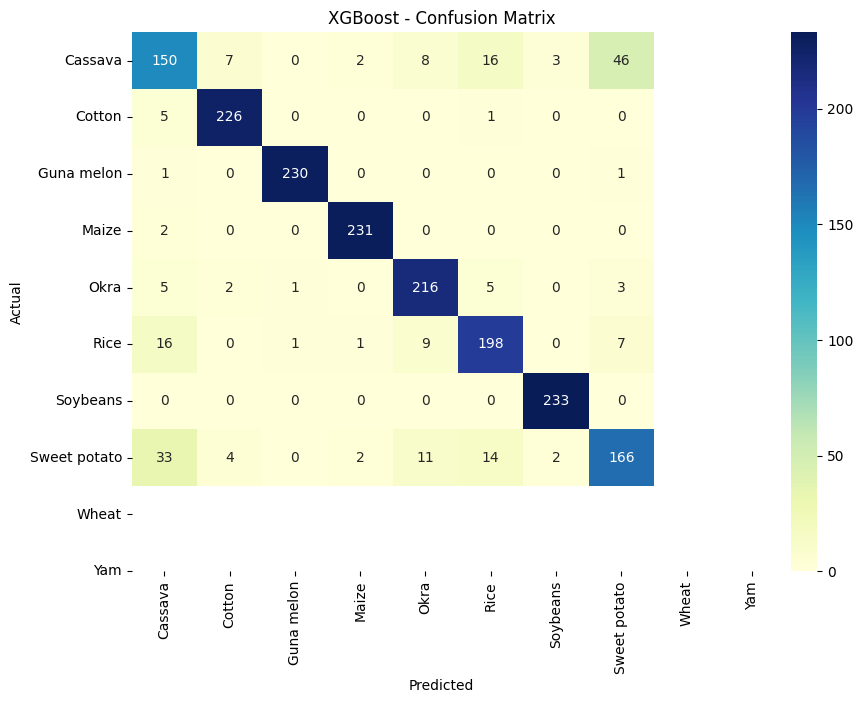

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=encoders['best_crop'].classes_,
            yticklabels=encoders['best_crop'].classes_,
            cmap='YlGnBu')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost - Confusion Matrix')
plt.show()

In [21]:
import joblib

joblib.dump(xgb, "north_crop_yield_model.pkl")

['north_crop_yield_model.pkl']